# Homework Solutions

## Data Exploration

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

In [6]:
data = pd.read_csv('car_fuel_efficiency.csv')

In [7]:
data.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [8]:
base_columns = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]

In [9]:
df = data[base_columns].copy()
df

engine_displacement  horsepower  vehicle_weight  model_year  \
0                     170       159.0     3413.433759        2003   
1                     130        97.0     3149.664934        2007   
2                     170        78.0     3079.038997        2018   
3                     220         NaN     2542.392402        2009   
4                     210       140.0     3460.870990        2009   
...                   ...         ...             ...         ...   
9699                  140       164.0     2981.107371        2013   
9700                  180       154.0     2439.525729        2004   
9701                  220       138.0     2583.471318        2008   
9702                  230       177.0     2905.527390        2011   
9703                  270       140.0     2908.043477        2005   

      fuel_efficiency_mpg  
0               13.231729  
1               13.688217  
2               14.246341  
3               16.912736  
4               12.488369  
...                   ...  
9699            15.101802  
9700            17.962326  
9701            17.186587  
9702            15.331551  
9703            14.884467  

[9704 rows x 5 columns]

### Look at the fuel_efficiency_mpg variable. Does it have a long tail?
No, it does not have a long tail.

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

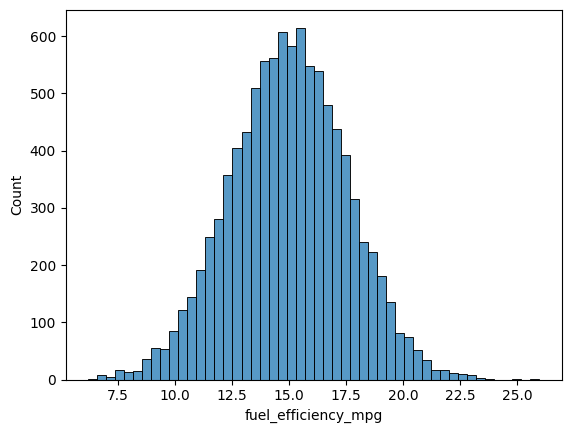

In [10]:
sns.histplot(df.fuel_efficiency_mpg, bins=50)

## Question 1
There's one column with missing values. What is it?

* 'engine_displacement'
* 'horsepower'
* 'vehicle_weight'
* 'model_year'

In [11]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

## Question 2

What's the median (50% percentile) for variable `'horsepower'`?

- 49
- 99
- 149
- 199


In [12]:
# What's the median (50% percentile) for variable `'horsepower'`?
median = df.horsepower.median()
print(median)

149.0


### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [13]:
def prepare_splits(df, val_size=0.2, test_size=0.2, random_state=42):
    df = df.copy()
    
    # Shuffle the dataset (the filtered one you created above), use seed=42.
    idx = np.arange(len(df))
    np.random.seed(random_state)           # Seed to keep the same random order on new runs
    np.random.shuffle(idx)
    
    # Splits
    n_total = len(df)
    n_val = int(n_total * val_size)
    n_test = int(n_total * test_size)
    n_train = n_total - n_val - n_test
    
    # Split your data in train/val/test sets, with 60%/20%/20% distribution.
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]

    # Reset indexes
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    assert len(df_train) + len(df_val) + len(df_test) == len(df), "Something went wrong with the splits!"
    
    return df_train, df_val, df_test
    

In [14]:
def prepare_y(df, target_column='fuel_efficiency_mpg'):
    # Extract the dataframe target values
    y = df[target_column].values
    
    # Remove target from dataframes
    del df[target_column]
    return y
    

In [15]:
df_train, df_val, df_test = prepare_splits(df)

In [16]:
y_train = prepare_y(df_train)
y_val = prepare_y(df_val)
y_test = prepare_y(df_test)

## Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good

### We need to deal with missing values for the column from Q1.


In [17]:
# Recap Q1
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

### We have two options: fill it with 0 or with the mean of this variable.

### Try both options. For each, train a linear regression model without regularization using the code from the lessons.

In [18]:
base = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
]

In [19]:
def train_linear_regression(X, y):
    # Define ones vector for bias term (aka intercept)
    ones = np.ones(X.shape[0])
    
    # Column stack ones to X
    X = np.column_stack([ones, X])

    # Gram Matrix (aka X^T * X) 
    XTX = X.T.dot(X)
    
    # Inverse of Gram Matrix
    XTX_inv = np.linalg.inv(XTX)
    
    # Weight vector
    w_full = XTX_inv.dot(X.T).dot(y)
    
    # Bias term
    w0 = w_full[0]
    
    # Weights
    w = w_full[1:]
    
    return w0, w

### Use the validation dataset to evaluate the models and compare the RMSE of each option.

In [20]:
def prepare_X(df, fill_method):
    df_num = df[base]
    df_num = df_num.fillna(fill_method)
    X = df_num.values
    return X    
    

In [21]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [26]:
del X_train

In [ ]:
# Using Zeroes
X_train_zero = prepare_X(df_train, fill_method=0)
w0_zero, w_zero = train_linear_regression(X_train_zero, y_train)

In [30]:
# Validation Using Zeroes
X_val_zero = prepare_X(df_val, fill_method=0)
y_val_pred_zero = w0_zero + X_val_zero.dot(w_zero)

In [ ]:
# Using Mean
X_train_mean = prepare_X(df_train, fill_method=df_train.mean())
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)



In [ ]:
# Validation Using Mean
X_val_mean = prepare_X(df_val, fill_method=df_val.mean())
y_val_pred_mean = w0_mean + X_val_mean.dot(w_mean)


In [235]:
### RMSE scores
score_zero = rmse(y_val, y_val_pred_zero)
score_mean = rmse(y_val, y_val_pred_mean)

In [236]:
# Round the RMSE scores to 2 decimal digits using `round(score, 2)`
print("RMSE using fillna with 0: ", round(score_zero, 2))
print("RMSE using fillna with mean: ", round(score_mean, 2))

RMSE using fillna with 0:  28.83
RMSE using fillna with mean:  0.46


In [232]:
w0_zero 

0

### Which option gives better RMSE?
- With mean

## Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If multiple options give the same best RMSE, select the smallest `r`.

Options:

- 0
- 0.01
- 1
- 10
- 100

### Now let's train a regularized linear regression.

In [191]:
def train_linear_regression_reg(X, y, r=0.001):
    # Define ones vector for bias term (aka intercept)
    ones = np.ones(X.shape[0])
    
    # Column stack ones to X
    X = np.column_stack([ones, X])

    # Gram Matrix (aka X^T * X) 
    XTX = X.T.dot(X)
    
    # Regularization term
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    # Inverse of Gram Matrix
    XTX_inv = np.linalg.inv(XTX)
    
    # Weight vector
    w_full = XTX_inv.dot(X.T).dot(y)
    
    # Bias term
    w0 = w_full[0]
    
    # Weights
    w = w_full[1:]
    
    return w0, w

### For this question, fill the NAs with 0. 


In [196]:
X_train = prepare_X(df_train, fill_method=0)
X_val = prepare_X(df_val, fill_method=0)

### Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.

In [214]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)
    rmse_score = rmse(y_val, y_pred)
    # Round the RMSE scores to 2 decimal digits.
    print(f'r:{r} \t-->\t RMSE:', round(rmse_score, 2))


r:0 	-->	 RMSE: 0.52
r:0.01 	-->	 RMSE: 0.52
r:0.1 	-->	 RMSE: 0.52
r:1 	-->	 RMSE: 0.52
r:5 	-->	 RMSE: 0.52
r:10 	-->	 RMSE: 0.52
r:100 	-->	 RMSE: 0.52


## Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 0.001
- 0.006
- 0.060
- 0.600

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

### Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.


In [217]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### For each seed, do the train/validation/test split with 60%/20%/20% distribution.

In [ ]:
def seed_test(seeds):
    for seed in seeds:
        df_train, df_val, df_test = prepare_splits(df, val_size=0.2, test_size=0.2, random_state=seed)
        y_train = prepare_y(df_train)
        y_val = prepare_y(df_val)
        y_test = prepare_y(df_test)
        
        # Fill the missing values with 0 and train a model without regularization.
        X_train = prepare_X(df_train, fill_method=0)
        w0, w = train_linear_regression()
        
        

In [221]:
seed_test(seeds)